In [11]:
import glob
import netCDF4
from netCDF4 import Dataset
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.basemap import Basemap

In [21]:
# Having run first run "Sentinel-5P-Demo.py," we glob the acquired files:
all_data_files = glob.glob('/home/ubuntu/Sentinel-5P-Demo/*.nc')

# We open the first .nc file as a netCDF Dataset:
rg = Dataset(all_data_files[0],"r")

# We list the available variables:
av = rg.groups['PRODUCT'].variables
for key, value in av.items():
        print(key)

scanline
ground_pixel
time
corner
polynomial_exponents
intensity_offset_polynomial_exponents
layer
vertices
latitude
longitude
delta_time
time_utc
qa_value
nitrogendioxide_tropospheric_column
nitrogendioxide_tropospheric_column_precision
nitrogendioxide_tropospheric_column_precision_kernel
averaging_kernel
air_mass_factor_troposphere
air_mass_factor_total
tm5_tropopause_layer_index
tm5_constant_a
tm5_constant_b


/home/ubuntu/Sentinel-5P-Demo/S5P_OFFL_L2__NO2____20190202T050215_20190202T064345_06765_01_010202_20190208T072030.nc


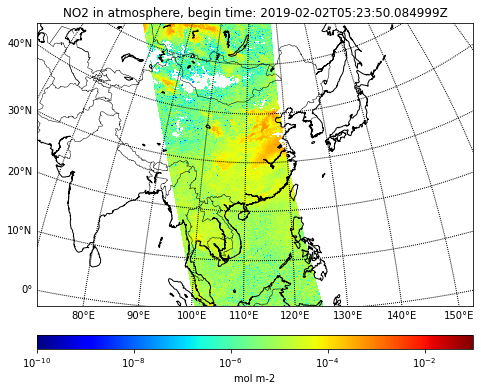

/home/ubuntu/Sentinel-5P-Demo/S5P_OFFL_L2__NO2____20190203T044318_20190203T062448_06779_01_010202_20190209T063947.nc


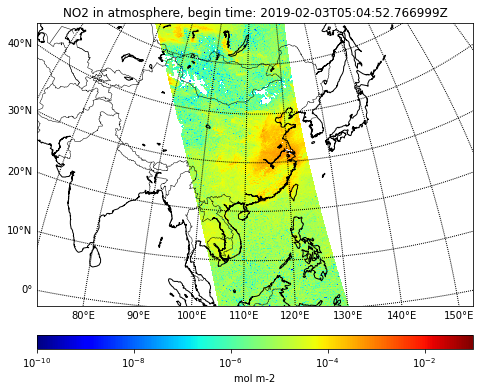

/home/ubuntu/Sentinel-5P-Demo/S5P_OFFL_L2__NO2____20190204T042421_20190204T060551_06793_01_010202_20190210T062618.nc


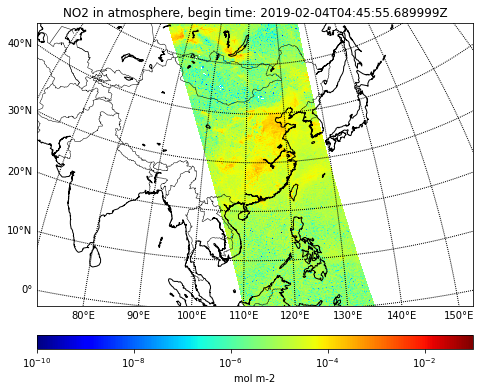

In [13]:
# First, we confirm that the data is in fact what we have requested; 
# namely: NO2 data intersecting Wuhan from 2019-02-02 to 2019-02-04.

for fn in all_data_files:
    print(fn)
    rg = Dataset(fn,"r")
    begintime = rg.groups['PRODUCT']['time_utc'][0][0]
    
    lons = rg.groups['PRODUCT'].variables['longitude'][:][0,:,:]
    lats = rg.groups['PRODUCT'].variables['latitude'][:][0,:,:]
    no2 = rg.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column'][0,:,:]
    no2_units = rg.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column'].units
       
    lon_0 = 112.224510 
    lat_0 = 29.613982

    plt.figure(figsize=(12,6))
    m = Basemap(width=10000000,height=6500000,
                resolution='l',projection='stere',\
                lat_ts=40,lat_0=lat_0,lon_0=lon_0)


    xi, yi = m(lons, lats)

    # Plot Data
    cs = m.pcolor(xi,yi,np.squeeze(no2),norm=LogNorm(), cmap='jet',  vmin=10e-11, vmax=10e-2 )

    # Add Grid Lines
    m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
    m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)

    # Add Coastlines, States, and Country Boundaries
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()

    # Add Colorbar
    cbar = m.colorbar(cs, location='bottom', pad="10%")
    cbar.set_label(no2_units)

    # Add Title
    plt.title('NO2 in atmosphere, begin time: '+ begintime)
    plt.rcParams["figure.figsize"] = [32,18]

    plt.show()

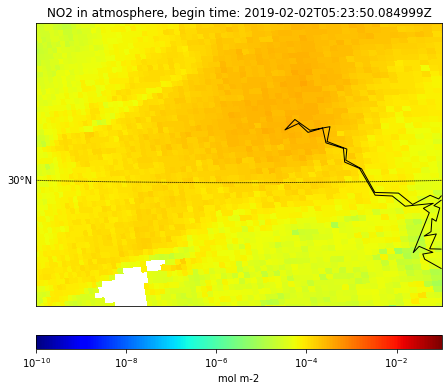

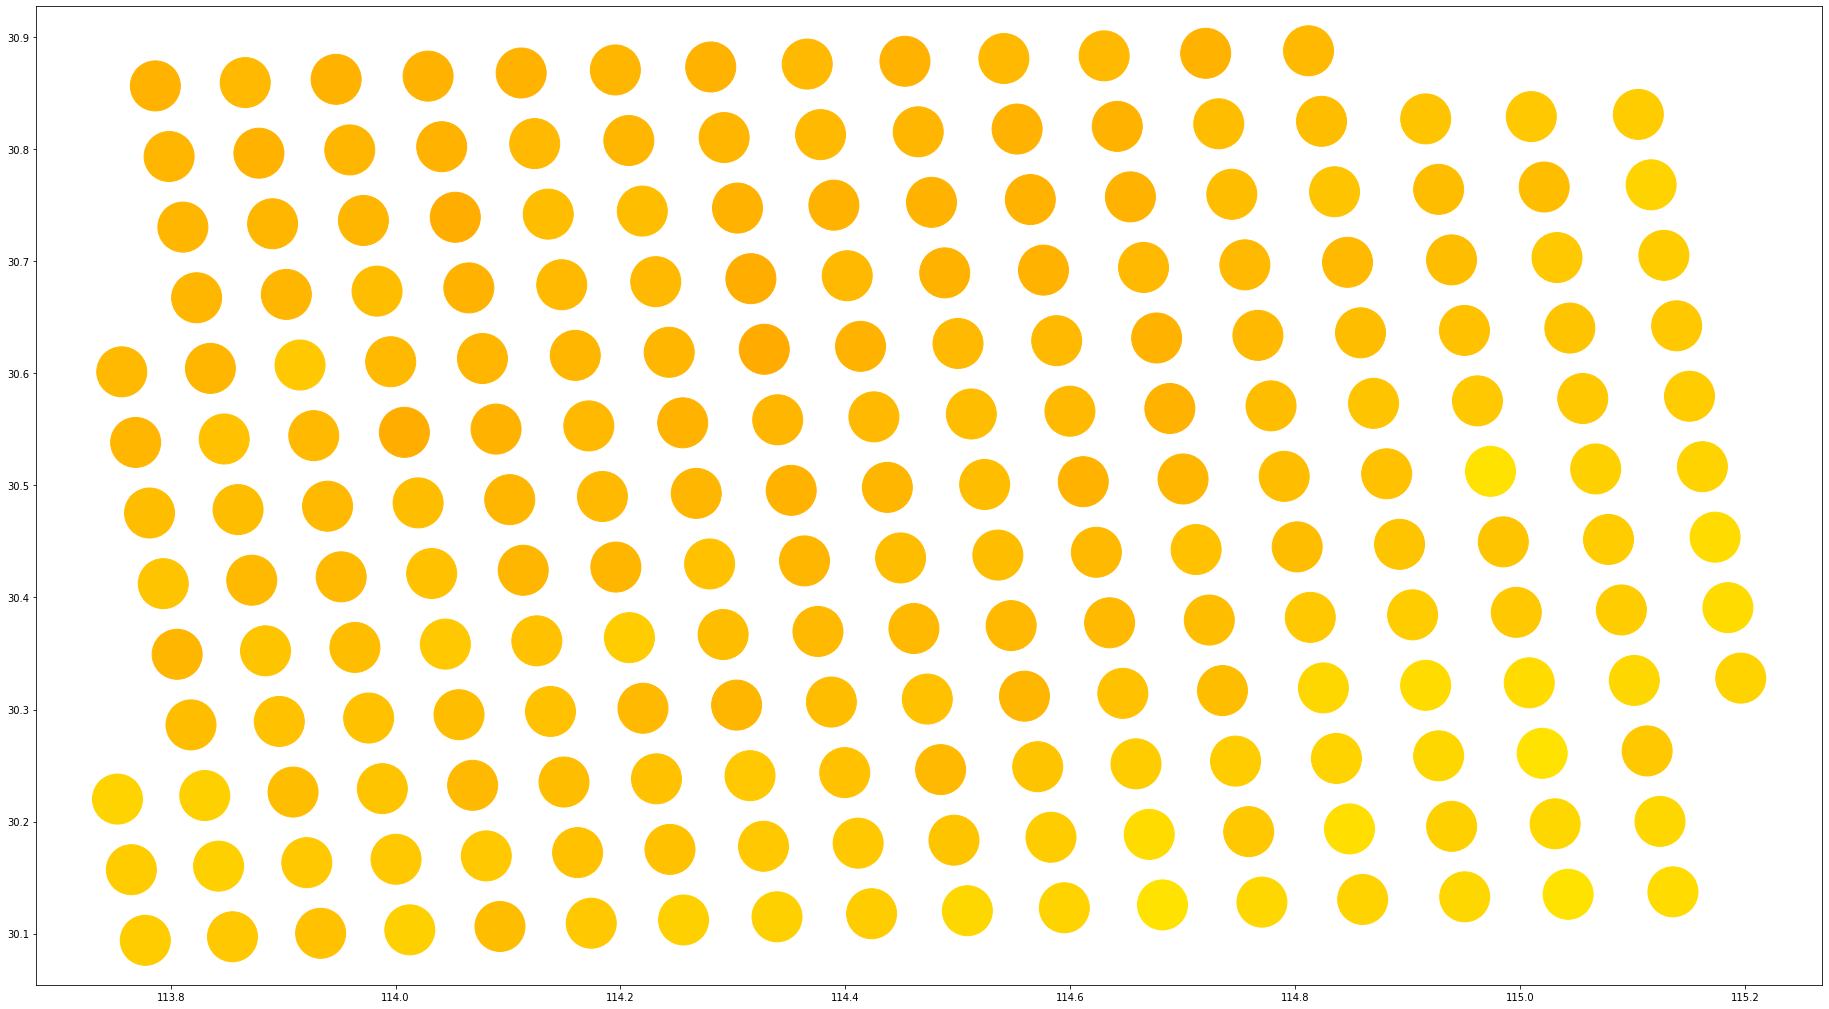

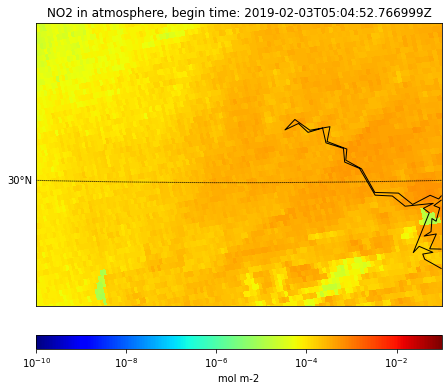

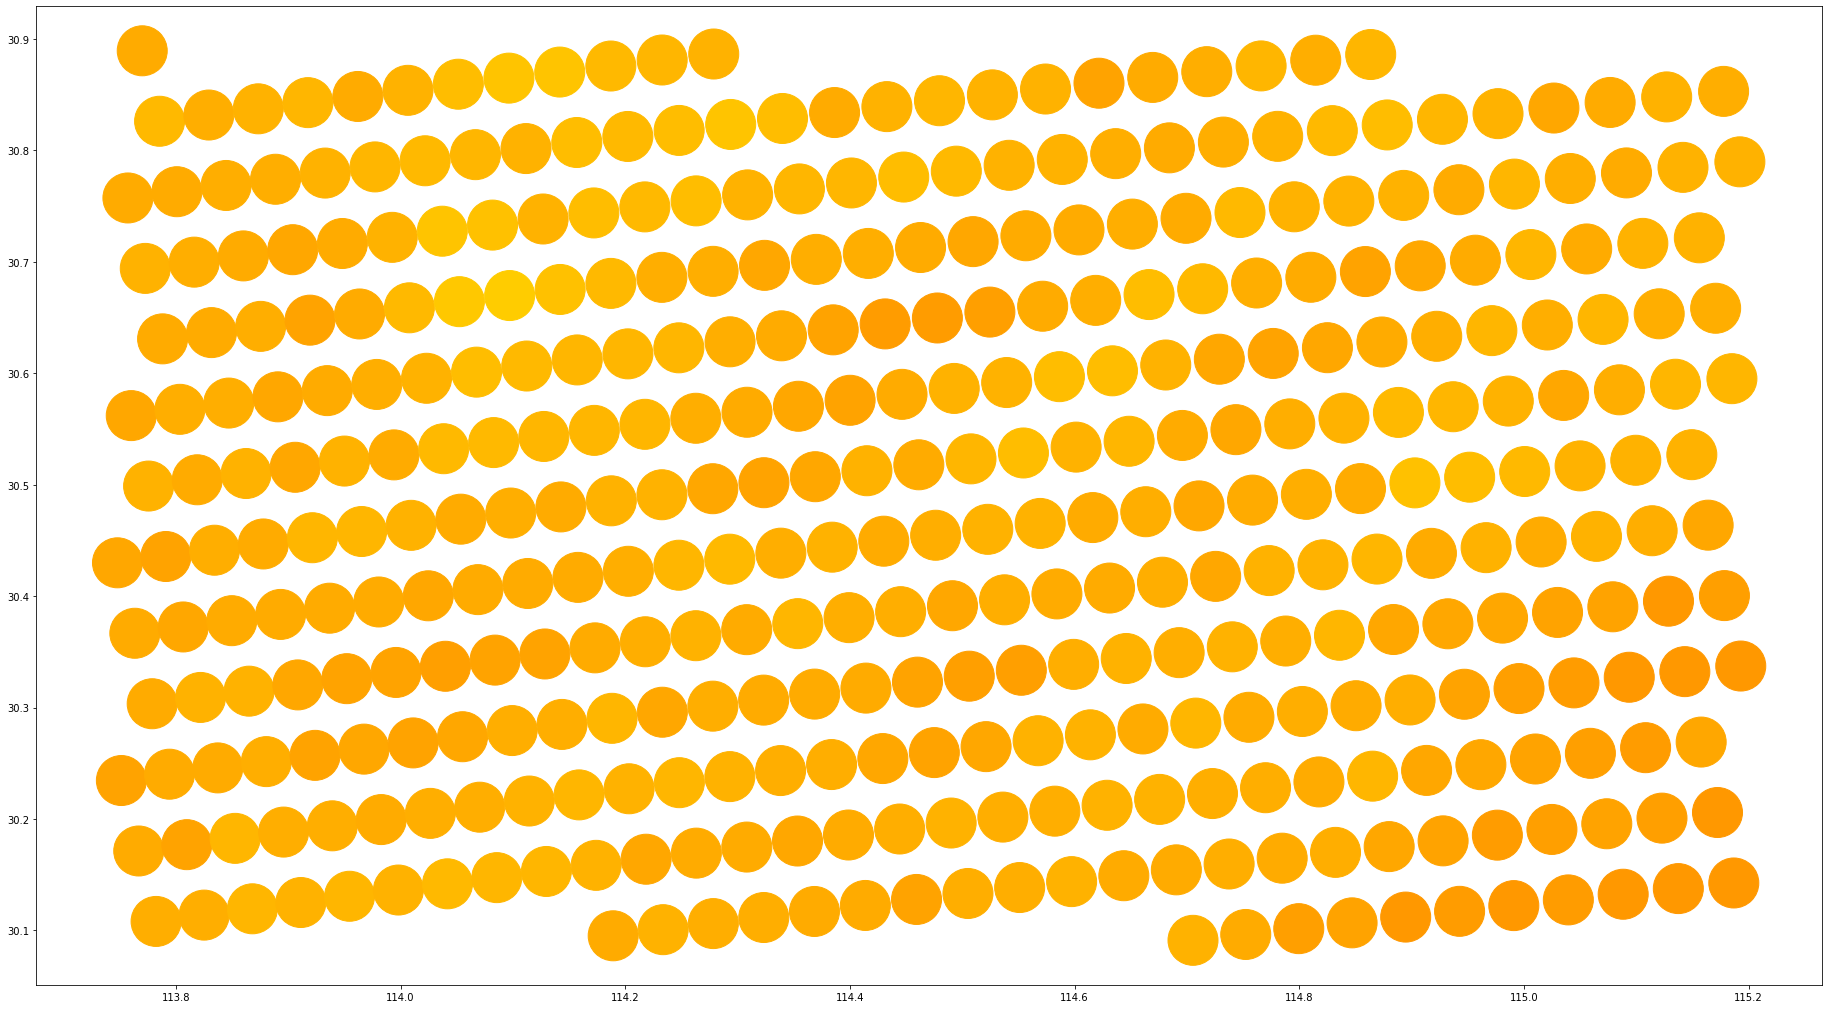

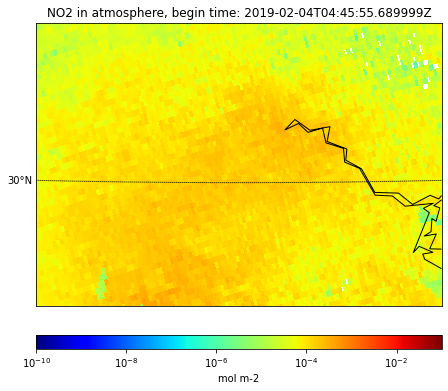

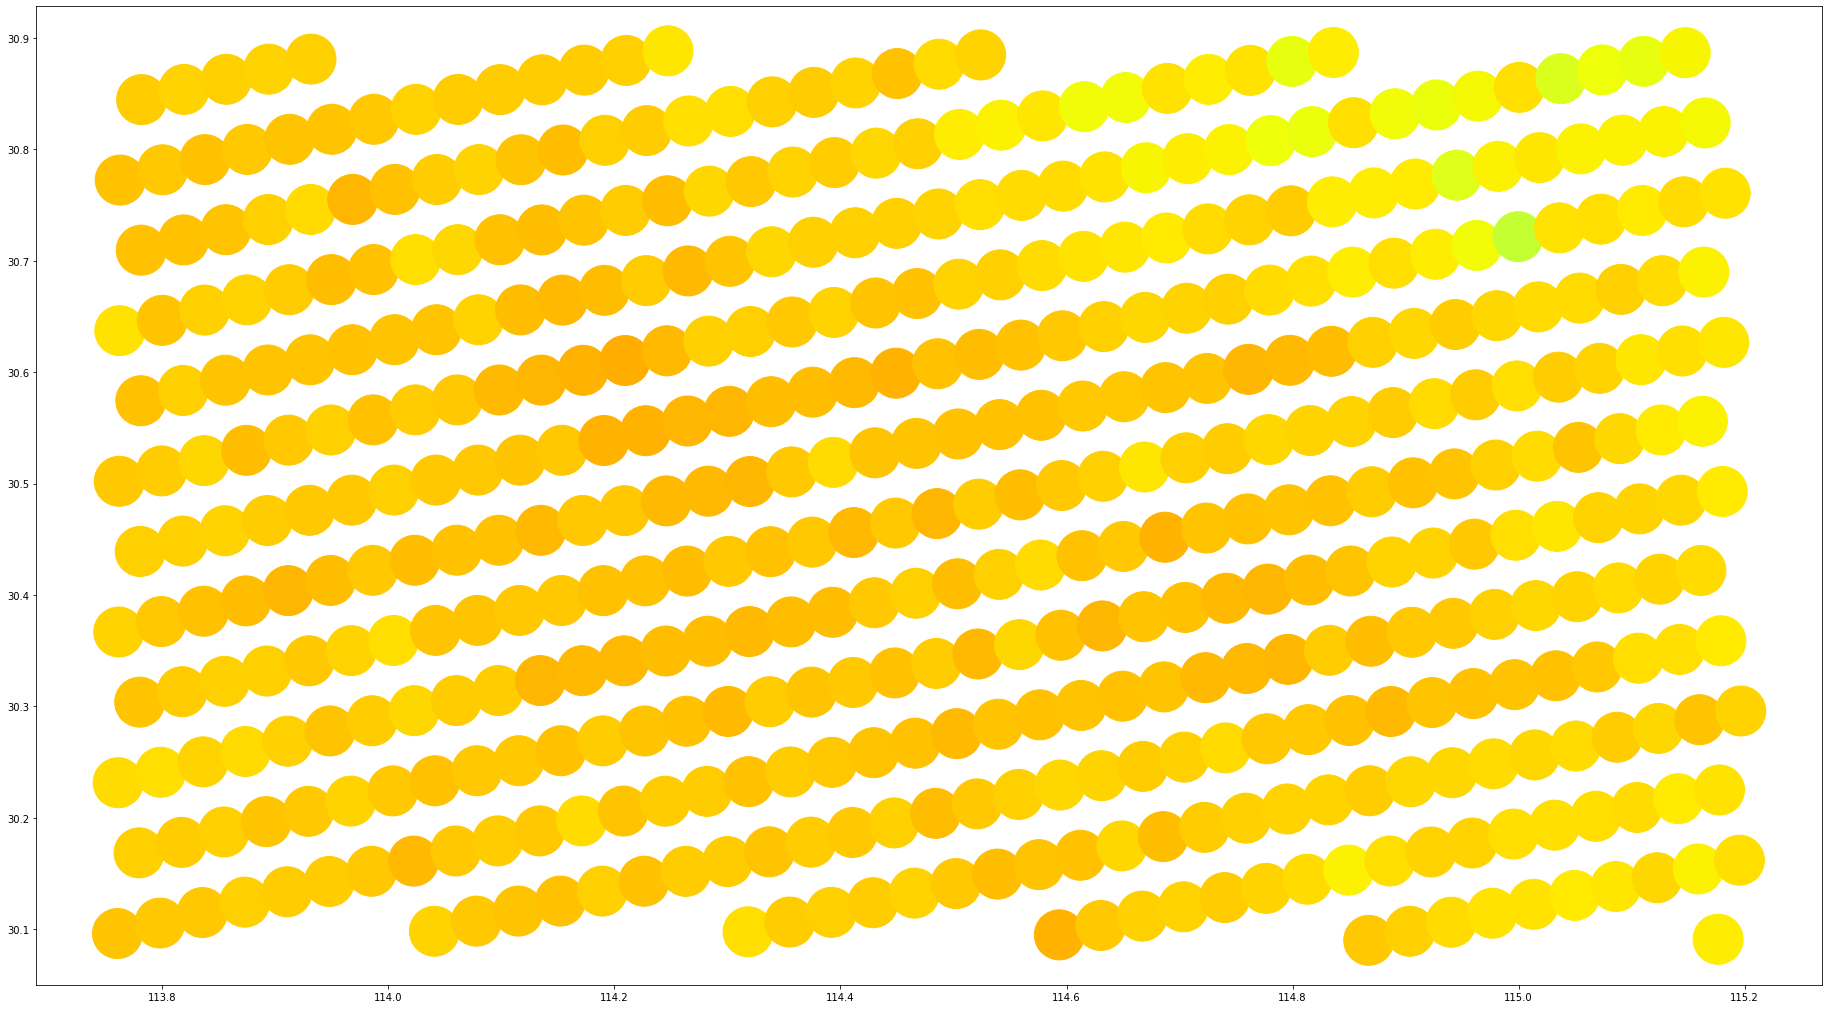

In [17]:
# Finally, we plot the data in our bounding box for Wuhan, and additionally
# scatterplot the latitude and longitudes near the city center, demonstrating
# the daily change in scanline orientation.

import pandas as pd

for fn in all_data_files:
    rg = Dataset(fn,"r")
    begintime = rg.groups['PRODUCT']['time_utc'][0][0]
    
    lons = rg.groups['PRODUCT'].variables['longitude'][:][0,:,:]
    lats = rg.groups['PRODUCT'].variables['latitude'][:][0,:,:]
    no2 = rg.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column'][0,:,:]
    no2_units = rg.groups['PRODUCT'].variables['nitrogendioxide_tropospheric_column'].units

    lon_0 = 113.7 
    lat_0 = 30.2

    plt.figure(figsize=(12,6))
    m = Basemap(width=500000,height=350000,
                resolution='l',projection='stere',\
                lat_ts=30,lat_0=lat_0,lon_0=lon_0)

    xi, yi = m(lons, lats)

    # Plot Data
    cs = m.pcolor(xi,yi,np.squeeze(no2),norm=LogNorm(), cmap='jet',  vmin=10e-11, vmax=10e-2 )

    # Add Grid Lines
    m.drawparallels(np.arange(-80., 81., 10.), labels=[1,0,0,0], fontsize=10)
    m.drawmeridians(np.arange(-180., 181., 10.), labels=[0,0,0,1], fontsize=10)

    # Add Coastlines, States, and Country Boundaries
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()

    # Add Colorbar
    cbar = m.colorbar(cs, location='bottom', pad="10%")
    cbar.set_label(no2_units)

    # Add Title
    plt.title('NO2 in atmosphere, begin time: '+ begintime)
    plt.rcParams["figure.figsize"] = [32,18]
    plt.show()
    
    # A smaller bounding box for Wuhan:
    bbox = [30.089667,113.747581,30.889630,115.197777]

    scanlines = lons.shape[0]
    ground_pixels = lons.shape[1]

    harr = []
    nv = []

    inlat = []
    inlon = []
    inv = []

    for i in range(0,scanlines): # H
        warr = []
        for j in range(0,ground_pixels): # W
            if (lats[i,j] > bbox[0] and lats[i,j] < bbox[2] and lons[i,j] > bbox[1] and lons[i,j] < bbox[3] ): 
                warr.append(no2[i,j])
                nv.append([lats[i,j],lons[i,j],no2[i,j]])
                inlat.append(lats[i,j])
                inlon.append(lons[i,j])
                inv.append(no2[i,j])
        if(len(warr)>0):
            harr.append(warr)
            
    mdict = {'lat': inlat, 'lon': inlon, 'no2': inv} 
    x = pd.DataFrame(mdict)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    s = ax.scatter(x.lon, x.lat, c=x.no2, s=2500.0, norm=LogNorm(), cmap= "jet", vmin=10e-11, vmax=10e-2)
    plt.show()
